#  **OBJECTIVE**

![](http://images.ctfassets.net/cnu0m8re1exe/3Rom6Wl30JAyXQfPBR2kgx/357c8172c06a2f45b1e5222c1b69d764/shutterstock_2070009056.jpg?fm=jpg&fl=progressive&w=660&h=433&fit=fill)

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

    Introversion (I) – Extroversion (E)
    Intuition (N) – Sensing (S)
    Thinking (T) – Feeling (F)
    Judging (J) – Perceiving (P)
    
This is a tool which is frequently used to help individuals understand their own communication preference and how they interact with others. Having an awareness of what MBTI you have can help you adapt your interpersonal approach to different situations and audiences.

So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

It is one of, if not the, the most popular personality test in the world. It is used in businesses, online, for fun, for research and lots more. A simple google search reveals all of the different ways the test has been used over time. It’s safe to say that this test is still very relevant in the world in terms of its use.

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
data=pd.read_csv('../input/mbti-type/mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [2]:
data.describe(include='O')

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'Sometimes. And my Chinese zodiac sign's a dog...
freq,1832,1


In [3]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

### From above we can see that there are many links in the text data. That needed to be removed.

In [6]:
# Stratify split to ensure equal distribution of data

train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

### Function to clean the text data.

In [7]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [8]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:06<00:00, 1059.26it/s]


In [9]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:02<00:00, 789.50it/s]


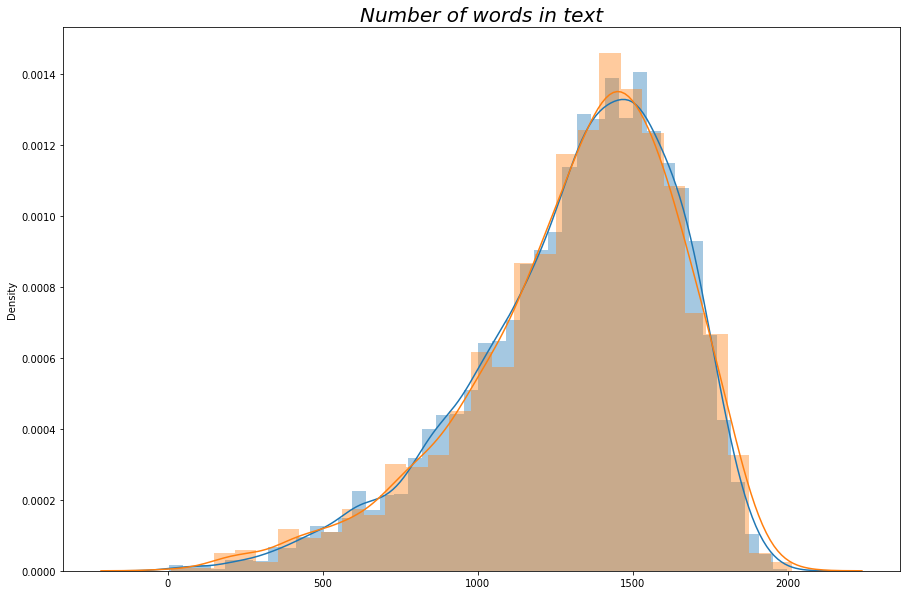

In [10]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [11]:

px.pie(train_data,names='type',title='Personality type',hole=0.3)


In [12]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [13]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x7f5aa41f5350>)

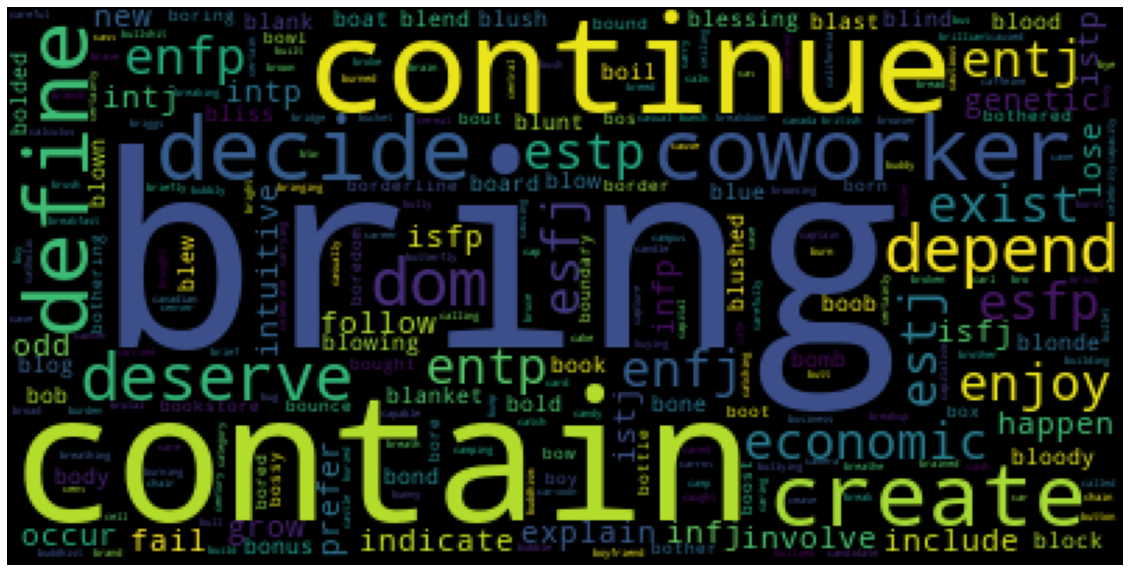

In [14]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [15]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [16]:
train_post.shape

(6940, 5000)

In [17]:
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

In [18]:
models_accuracy={}

<h4 style="background-color:#A9CCE3;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px ">Logistic Regression</h4>

In [19]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [20]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.81      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.73      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1465
        INTJ       0.73      0.80      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.24      0.38       133
        ISFP       0.86      0.26      0.40       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.52      0.65       270

    accuracy                           0.72      

In [21]:
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.08      0.15        38
        ENFP       0.76      0.53      0.62       135
        ENTJ       0.75      0.13      0.22        46
        ENTP       0.66      0.51      0.58       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.64      0.71      0.67       294
        INFP       0.57      0.88      0.69       367
        INTJ       0.61      0.65      0.63       218
        INTP       0.66      0.83      0.74       261
        ISFJ       0.67      0.12      0.21        33
        ISFP       0.85      0.20      0.33        54
        ISTJ       0.60      0.07      0.13        41
        ISTP       0.68      0.45      0.54        67

    accuracy                           0.63      17

In [22]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

<h4 style="background-color:#A9CCE3;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px ">Linear Support Vector classifier</h4>

In [23]:
model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

LinearSVC(C=0.1)

In [24]:
print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.89      0.45      0.60       152
        ENFP       0.85      0.76      0.80       540
        ENTJ       0.92      0.65      0.76       185
        ENTP       0.84      0.82      0.83       548
        ESFJ       0.83      0.29      0.43        34
        ESFP       1.00      0.11      0.19        38
        ESTJ       1.00      0.26      0.41        31
        ESTP       0.92      0.49      0.64        71
        INFJ       0.82      0.86      0.84      1176
        INFP       0.77      0.93      0.84      1465
        INTJ       0.83      0.85      0.84       873
        INTP       0.81      0.89      0.85      1043
        ISFJ       0.91      0.67      0.77       133
        ISFP       0.89      0.57      0.70       217
        ISTJ       0.87      0.66      0.75       164
        ISTP       0.89      0.83      0.86       270

    accuracy                           0.82      

In [25]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

<h4 style="background-color:#A9CCE3;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px ">Support Vector classifier</h4>

In [26]:
model_svc=SVC()
model_svc.fit(train_post,train_target)

SVC()

In [27]:

print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.97      0.84      0.90       152
        ENFP       0.96      0.95      0.95       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.95      0.96      0.95       548
        ESFJ       1.00      0.56      0.72        34
        ESFP       1.00      0.37      0.54        38
        ESTJ       1.00      0.52      0.68        31
        ESTP       1.00      0.82      0.90        71
        INFJ       0.95      0.97      0.96      1176
        INFP       0.92      0.98      0.95      1465
        INTJ       0.96      0.96      0.96       873
        INTP       0.94      0.97      0.96      1043
        ISFJ       1.00      0.89      0.94       133
        ISFP       0.97      0.90      0.94       217
        ISTJ       0.94      0.92      0.93       164
        ISTP       0.97      0.94      0.95       270

    accuracy                           0.95      

In [28]:
models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))

<h4 style="background-color:#cc99ff;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 15px 50px;padding: 5px ">Multinomial Naive Bayes</h4>

In [29]:
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [30]:

print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.90      0.02      0.03       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.91      0.06      0.11       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.52      0.62      0.56      1176
        INFP       0.35      0.94      0.52      1465
        INTJ       0.78      0.42      0.54       873
        INTP       0.58      0.64      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       1.00      0.00      0.01       270

    accuracy                           0.46      

In [31]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

<h4 style="background-color:#A9CCE3;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px ">Decision Tree Classifier</h4>

In [32]:
model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

DecisionTreeClassifier(max_depth=14)

In [33]:

print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.75      0.59      0.66       152
        ENFP       0.87      0.79      0.83       540
        ENTJ       0.94      0.67      0.78       185
        ENTP       0.93      0.76      0.84       548
        ESFJ       0.93      0.38      0.54        34
        ESFP       0.90      0.24      0.38        38
        ESTJ       0.83      0.32      0.47        31
        ESTP       0.84      0.44      0.57        71
        INFJ       0.81      0.85      0.83      1176
        INFP       0.62      0.94      0.75      1465
        INTJ       0.87      0.79      0.83       873
        INTP       0.89      0.81      0.85      1043
        ISFJ       0.98      0.47      0.63       133
        ISFP       0.97      0.62      0.75       217
        ISTJ       0.96      0.52      0.68       164
        ISTP       0.97      0.70      0.81       270

    accuracy                           0.79      

In [34]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))

<h4 style="background-color:#A9CCE3;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px ">Random Forest Classifier</h4>

In [35]:
model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(train_post,train_target)

RandomForestClassifier(max_depth=10)

In [36]:

print('train classification report \n ',classification_report(train_target,model_forest.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_forest.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.01      0.03       152
        ENFP       0.98      0.39      0.56       540
        ENTJ       1.00      0.08      0.14       185
        ENTP       0.99      0.54      0.70       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.01      0.03        71
        INFJ       0.82      0.85      0.84      1176
        INFP       0.45      1.00      0.62      1465
        INTJ       0.89      0.75      0.82       873
        INTP       0.78      0.88      0.83      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       1.00      0.02      0.05       217
        ISTJ       1.00      0.03      0.06       164
        ISTP       1.00      0.14      0.25       270

    accuracy                           0.66      

In [37]:
models_accuracy['Random Forest Classifier']=accuracy_score(test_target,model_forest.predict(test_post))

<h4 style="background-color:#A9CCE3;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px ">XGBoost Classifier</h4>

In [38]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(train_post,train_target)

[08:45:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [39]:

print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.99      0.92      0.95       152
        ENFP       0.94      0.91      0.92       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.94      0.91      0.92       548
        ESFJ       1.00      0.91      0.95        34
        ESFP       1.00      0.92      0.96        38
        ESTJ       1.00      0.84      0.91        31
        ESTP       1.00      0.94      0.97        71
        INFJ       0.91      0.90      0.91      1176
        INFP       0.89      0.95      0.92      1465
        INTJ       0.92      0.92      0.92       873
        INTP       0.90      0.93      0.91      1043
        ISFJ       1.00      0.96      0.98       133
        ISFP       0.99      0.92      0.95       217
        ISTJ       0.99      0.92      0.95       164
        ISTP       0.97      0.96      0.96       270

    accuracy                           0.92      

In [40]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))

<h4 style="background-color:#A9CCE3;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;padding: 5px ">CatBoost Classifier</h4>

In [41]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
model_cat.fit(train_post,train_target)

In [42]:

print('train classification report \n ',classification_report(train_target,model_cat.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_cat.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.87      0.54      0.67       152
        ENFP       0.81      0.75      0.78       540
        ENTJ       0.89      0.59      0.71       185
        ENTP       0.78      0.78      0.78       548
        ESFJ       0.93      0.41      0.57        34
        ESFP       1.00      0.24      0.38        38
        ESTJ       1.00      0.35      0.52        31
        ESTP       0.93      0.56      0.70        71
        INFJ       0.79      0.82      0.81      1176
        INFP       0.77      0.88      0.82      1465
        INTJ       0.80      0.81      0.81       873
        INTP       0.75      0.86      0.80      1043
        ISFJ       0.88      0.63      0.73       133
        ISFP       0.80      0.64      0.71       217
        ISTJ       0.87      0.66      0.75       164
        ISTP       0.88      0.75      0.81       270

    accuracy                           0.79      

In [43]:
models_accuracy['CatBoost Classifier']=accuracy_score(test_target,model_cat.predict(test_post))

# **Now we will check the Accuracy of all the models used above:**

In [44]:
models_accuracy

{'logistic regression': 0.6282420749279539,
 'Linear Support Vector classifier': 0.661671469740634,
 'Support Vector classifier': 0.6489913544668587,
 'Multinomial Naive Bayes': 0.37809798270893374,
 'Decision Tree classifier': 0.5100864553314121,
 'Random Forest Classifier': 0.4478386167146974,
 'XGBoost Classifier': 0.6662824207492796,
 'CatBoost Classifier': 0.6685878962536023}

In [45]:
models_accuracy.keys()

dict_keys(['logistic regression', 'Linear Support Vector classifier', 'Support Vector classifier', 'Multinomial Naive Bayes', 'Decision Tree classifier', 'Random Forest Classifier', 'XGBoost Classifier', 'CatBoost Classifier'])

In [46]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

In [47]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

,Models,Test accuracy
0,CatBoost Classifier,0.668588
1,XGBoost Classifier,0.666282
2,Linear Support Vector classifier,0.661671
3,Support Vector classifier,0.648991
4,logistic regression,0.628242
5,Decision Tree classifier,0.510086
6,Random Forest Classifier,0.447839
7,Multinomial Naive Bayes,0.378098


# **Accuracy of CatBoost Classifier is the highest**